# Imports

In [ ]:
import pandas as pd
import numpy as np
# Data Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale= 2)

import re
import string
import os
from tqdm import tqdm
from time import time


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms, datasets, models
from PIL import Image

from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report

### Device

In [ ]:
if torch.cuda.is_available():
    print(f"GPU:{torch.cuda.get_device_name()}")
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    print(DEVICE)

### Helper Methods

In [3]:

def remainig_time(tt):
    if tt/60 < 1:
        return "{} sec".format(int(tt))
    if tt/60/60 < 1:
        return "{} min".format(int(tt/60))
    if tt/60/60/24 < 1:
        mins = tt/60
        hrs = mins/60
        return "{:.2f} hrs".format(hrs)
    if tt/60/60/24 > 1:
        days = tt/60/60/24
        return "{:.2f} days".format(days)


def save_model(model, optim, loss_train, loss_val, acc_train, acc_val, epoch, model_name, model_path=''):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'loss_train': loss_train,
        'loss_val': loss_val,
        'epoch': epoch,
        'acc_train': acc_train,
        'acc_val': acc_val,
    }, os.path.join(model_path, model_name))


def load_model(model_path, device=DEVICE):
    return torch.load(model_path, map_location=device)

### Constants

In [4]:
# Hyper Parameters (You can change as you like ... and see how it affects the results)
LR = 3e-5
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_RESIZE = (IMG_HEIGHT, IMG_WIDTH)
EPOCHS = 100
# Constants
NUM_WORKERS = 3 # Based on the 
NUM_CLASSES = 2
CLASSES = ['NORMAL', 'PNEUMONIA']
CHANNELS = 1
MIN_ACC = float('-inf')
# Data Path
DATA_PATH = '../input/chest-xray-pneumonia/chest_xray/'
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train/')
VAL_DATA_PATH = os.path.join(DATA_PATH, 'val/')
TEST_DATA_PATH = os.path.join(DATA_PATH, 'test/')

### Create Your Pipeline of image transformation

In [ ]:
# Transformation
TR = transforms.Compose([
    # 1- convert to GrayScale,
    # 2- Resize the Image,
    # 3- Convert Image data into tensor,
    # 4- Normalize your Image with mean=0.5, std=0.5 
])

### Dataset Preparation

In [6]:
%%time
df_train = ## Training And Validation Data Combined with columns: [image_path, label]
df_test = ## Testing Data with columns: [image_path, label]

CPU times: user 23.1 ms, sys: 19 ms, total: 42.1 ms
Wall time: 591 ms


In [7]:
print(f"Images in Training set: {df_train.shape[0]:,}")
print(f"Images in Testing set: {df_test.shape[0]:,}")

Images in Training set: 5,232
Images in Testing set: 624


In [8]:
df_train.sample(3)

,img_path,label
1940,../input/chest-xray-pneumonia/chest_xray/train...,1
140,../input/chest-xray-pneumonia/chest_xray/train...,0
2200,../input/chest-xray-pneumonia/chest_xray/train...,1


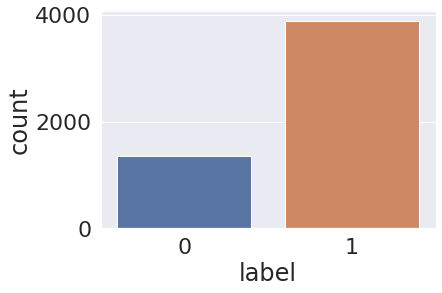

In [9]:
# Take a look at the Target Variable

Now given this high bias in our dataset ... we will fix it using 2 tricks ...
  - weighted loss   
  
  so when our model **wrongly predict class 0** (the minority class) ... we **punish him more than** if he predicted class 1 wrong (the majority class)
  - Balance the Evaluation dataset  
  
  we make our evalution dataset has same number of **class 0 and class 1** ... in-order to make the right decision when model has high accuracy

### Weighted Loss

In [ ]:
## Apply Weighted Loss w.r.t Size of label
## So class with low number of images get higher weight
## while class with High number of images get lower weight

weight = ## Write your code here
criterion = nn.NLLLoss(weight= weight).to(DEVICE)
# Show the Weights (should be close to this ==> [0.74, 0.25])
print(criterion.weight)

#### Training method

In [ ]:
def train_fn(batches, model, optim, scheduler, device=DEVICE):
    model.train() # set the model mode => training
    batch_acc = 0
    ep_loss = 0
    # Loop through the training batches
    for batch in tqdm(batches, total=len(batches), position=0, leave=True):
        
        imgs, labels = # Get Your image and targets from the given batch
        # Forward Propagation
        labels_pred = ## Get Your predictions from model
        # Calculate Loss
        loss = ## Get your loss bet. Predictions and Targets
        # Backward propagation (Check: https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944)
        ## - Zero your optimizer gradients
        ## - Calculate loss gradient
        ## - Make step with optimizer
        ## - Accumulating Loss & Accuracy Across batches
        ep_loss += loss.item()
        batch_acc += sum(labels == labels_pred.argmax(1)).item()
    # Calculate The whole Epoch Accuracy after the batches loop ends
    ep_acc = batch_acc / (BATCH_SIZE * len(batches))
    ## Return the ep_loss and the ep_acc
    return ep_loss, ep_acc

#### Evaluation method

In [ ]:
def eval_fn(batches, model, device=DEVICE):
    """
    Calculate the model accuracy & loss on given eval data ... no training is needed here
    just prediction and comparing results
    """
    ## Write your code here
    return ep_loss, ep_acc

#### Prediction method

In [ ]:
def pred_fn(batches, model, device=DEVICE):
    """
    Predict Test batches
    Args:
        batches (generator): Test Batches
        model (model object): Trained Model
        device (gpu/cpu device, optional): active device. Defaults to DEVICE.

    Returns:
        predictions: List of predictions
        true_labels: List of true labels
    """
    ## Write your code here
    return predictions, true_labels

### Dataset Class

In [88]:
class Dataset():

    def __init__(self, img_paths, targets, transform=None):
        ## Write your code here

    def __len__(self):
        ## Write your code here

    def __getitem__(self, item):
        ## Write your code here
        return {
            'images': ## Write your code here,
            'targets': ## Write your code here
            }

### Model

In [101]:
class XrayClassifier(nn.Module):
    def __init__(self, in_channels=1, out_channels=128, num_classes=2):
        super(XrayClassifier, self).__init__()
        # out_shape =  [ (n - k + 2*p) / s ] + 1
        # p: (default = 0) padding
        # s: (default = 1) stride
        # k: kernel
        # out_shape =  [n - k  + 1]
        
    def forward(self, x):
        ## Write your code here
        return out

##### Test your model with random input

In [102]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 1
BS = 1 # Batch Size
ex = torch.rand(BS, CHANNELS, IMG_WIDTH, IMG_HEIGHT)
model = XrayClassifier()
model.eval()
out = model(ex)
print(out.shape)
out

torch.Size([1, 2])


tensor([[-0.6931, -0.6931]], grad_fn=<LogSoftmaxBackward>)

### Split your Dataset

In [103]:
# Train Test Split with your custome balanced method
train_imgs, val_imgs, train_labels, val_labels = ## Write your code here

print(f"{len(train_imgs):,} Training imgs")
print(f"{len(val_imgs):,} Validation imgs")

4,186 Training imgs
1,046 Validation imgs


### Check Validation labels ... should be equal

In [ ]:
val_labels.value_counts()

### Dataset instances for Train, Val & Test

In [ ]:
train_dataset = ## Write your code here
val_dataset = ## Write your code here
test_dataset = ## Write your code here

### Data-Loader

In [ ]:
train_batches = ## Write your code here
val_batches = ## Write your code here
test_batches = ## Write your code here

### Initialize your model, optimizer

In [ ]:
model = ## Write your code here
optim = ## Write your code here # Note: Try with different optimizers and see how it affect the results...

In [ ]:
## Create History For saving your losses and accuracies
history= {}
history['train_loss'] = []
history['val_loss'] = []
history['train_acc'] = []
history['val_acc'] = []

### Training Loop

In [ ]:
for epoch in range(EPOCHS):
        s = time()
        # train
        ep_train_loss, ep_train_acc = train_fn(train_batches, model, optim, scheduler)
        # eval
        ep_val_loss, ep_val_acc = eval_fn(val_batches, model)
        e = time()

        epoch_t = remainig_time(e - s)
        whole_time = remainig_time((e - s) * (EPOCHS - epoch))
        print(f"\nEpoch:{epoch}/{EPOCHS}---Loss-train:{ep_train_loss:.4f}---Loss-Val: {ep_val_loss:.4f}---Acc-Train:{(ep_train_acc*100):.2f}%---Acc-Val: {(ep_val_acc*100):.2f}%---Acc-Test: {(ep_test_acc*100):.2f}---%epoch elapsed:{epoch_t}---Remaining:{whole_time}")
        
        ## Write your code here ## append the training loss
        ## Write your code here ## append the validation loss
        ## Write your code here ## append the training acc
        ## Write your code here ## append the validation acc

        if ep_val_acc > MIN_ACC:
            print("Saving Model ...")
            model_name = f'Xray_ep_{epoch}_acc_{(ep_test_acc*100):.3f}_.pth'
            MIN_ACC = ep_test_acc
            # Save Your model Checkpoint
            ## Write your code here

## Prediction

In [ ]:
MODEL_PATH = '' # Get your model path
checkpoint = load_model(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict']) # Just loading the model weights

In [ ]:
preds, labels = pred_fn(test_batches, model)

In [ ]:
print(f"Accuracy: {(np.array(preds) == np.array(labels)).mean()*100:.1f}% On Test Set")

In [ ]:
print(classification_report(labels, preds, target_names=CLASSES))

### Create a confusion matrix and plot it

In [ ]:
## Write your code here

# Great Work ... 💪💪

Now you're able to get and start applying your various types of ***DL approches*** and ***compete with many Kagglers***
There exist huge amount of images data out there ... that you're now able to give it a try and apply your own model on ... Good Start 👍👍😊